In [ ]:
# default_exp core
# default_cls_lvl 1

In [ ]:
#export
from fastai2.vision.all import *
import PIL.ImageCms

In [ ]:
#hide
from nbdev.showdoc import *

# Color Space

> Transforms and utilities related to color space

Images are typically encoded in the RGB space. However, other color spaces have been developped for different purposes.

We want to predict a colorized picture from a black & white version. Some color spaces have one of their channels corresponding to black & white, which is convenient as we then have to predict only 2 channels.

In order to define our neural network and loss, we would like to use a color space where the difference between two colors is more closely related to visual perception. The [CIELAB color space](https://en.wikipedia.org/wiki/CIELAB_color_space) was developped for this purpose and has one of his channel corresponding directly to the black & white version.

*Note: some more recent color spaces have been developed such as [CIECAM02](https://en.wikipedia.org/wiki/CIECAM02) to improve the correlation with visual perception. However we currently rely on [Pillow](https://github.com/python-pillow/Pillow) which does not handle these color space transformations.*

In [ ]:
#export
class PILImageLAB(PILImage):
    "PILImage in the LAB space"
    pass

In [ ]:
#export
class RGBToLAB(Transform):
    "Convert a PILImage from RGB to LAB space"
    order = ToTensor.order - 1  # perform before ToTensor
    rgb_profile = PIL.ImageCms.createProfile("sRGB")
    lab_profile  = PIL.ImageCms.createProfile("LAB")
    transform_rgb2lab = PIL.ImageCms.buildTransform(
        inputProfile=rgb_profile, outputProfile=lab_profile, inMode='RGB', outMode='LAB')
    transform_lab2rgb = PIL.ImageCms.buildTransform(
        inputProfile=lab_profile, outputProfile=rgb_profile, inMode='LAB', outMode='RGB')

    def encodes(self, x):
        return PILImageLAB(PIL.ImageCms.applyTransform(x, self.transform_rgb2lab))

    def decodes(self, x):
        return PILImage(PIL.ImageCms.applyTransform(x, self.transform_lab2rgb))

In [ ]:
#export
class TensorLAB(TensorImage):
    "Tensor for images in the LAB space"
    display = noop
    
    def show(self, **kwargs):
        displayTensor = self.display()
        pilImageLAB = ToTensor().decode(displayTensor)
        return RGBToLAB().decode(pilImageLAB).show(**kwargs)

# Add conversion to/from tensors
PILImageLAB._tensor_cls = TensorLAB  # used by `encodes`

@ToTensor
def decodes(self, o:TensorLAB): return PILImageLAB(Image.fromarray(np.uint8(o.permute(1,2,0)), mode='LAB'))

In [ ]:
#export
class TensorL(TensorLAB):
    "Tensor containing the L channel of an image"
    def display(self):
        blank_channel = torch.zeros_like(self[0])
        return TensorLAB(torch.stack((self[0], blank_channel, blank_channel), dim=0))

In [ ]:
#export
class TensorAB(TensorLAB):
    "Tensor containing A & B channels of an image"
    def display(self):
        "juxtapose both channels"
        blank_channel = torch.zeros_like(self[0])
        l_channel = torch.full_like(self[0], 128)
        img_A = torch.stack((l_channel, self[0], blank_channel), dim=0)
        img_B = torch.stack((l_channel, blank_channel, self[1]), dim=0)
        return TensorLAB(torch.cat((img_A, img_B), dim=2))

In [ ]:
#export
class Tuple_L_AB(Tuple):
    "Tuple with L channel and A & B channels"
    def display(self):
        img_L, img_AB = self
        return TensorLAB(torch.cat((img_L, img_AB), dim=0))

In [ ]:
#export
class Split_L_AB(ItemTransform):
    "Split TensorLAB into TensorL (input) & TensorAB (output)"
    order = ToTensor.order + 1  # perform after ToTensor    
    def encodes(self, x):
        return Tuple_L_AB((TensorL(x[0][None]), TensorAB(x[1:])))    
    def decodes(self, x):
        return Tuple_L_AB(x).display()

In [ ]:
#export
class AdjustType(Transform):
    "Cast A & B channels to correct type to have continuous values"
    order = Split_L_AB.order + 1    
    def encodes(self, x:(TensorAB)):
        return x.char()
    def decodes(self, x:(TensorAB)):
        return x.byte()

A & B channels are in the [0, 255] range, 0 being the neutral value.

However, a few tests show that 127 & 128 are the two extrema so we use `AdjustType` to recast to [-128, 127] range with those two values as extrema. 

In [ ]:
#export
@IntToFloatTensor
def encodes(self, o:TensorLAB):
    return o.float().div_(255.)

@IntToFloatTensor
def decodes(self, o:TensorAB):
    return o.mul_(255.).clamp(-128., 127.).char()

@IntToFloatTensor
def decodes(self, o:TensorL):
    return o.clamp(0., 1.).mul_(255.).byte()

In [ ]:
#export
@Normalize
def encodes(self, x:TensorAB): return x

@Normalize
def decodes(self, x:TensorAB): return x

We normalize only the input channel `TensorL` since the output `TensorAB` is already in [-0.5,0.5] range.

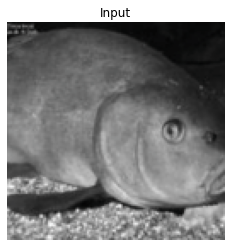

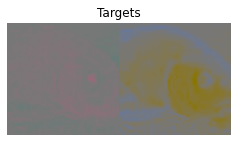

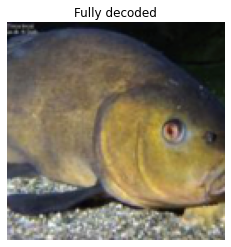

In [ ]:
# test Transforms
path = untar_data(URLs.IMAGENETTE_160)
items = get_image_files(path)
tls = TfmdLists(items, tfms=[PILImage.create, Resize(128), RGBToLAB(), ToTensor(), Split_L_AB()])
tensor_l, tensor_ab = tuple_l_ab = tls[0]
tensor_l.show(title='Input'), tensor_ab.show(title='Targets')
tls.decode(tuple_l_ab).show(title='Fully decoded');

L channel (input) going from -0.50 to 0.50
A channel (output) going from -0.24 to 0.31
B channel (output) going from -0.32 to 0.36


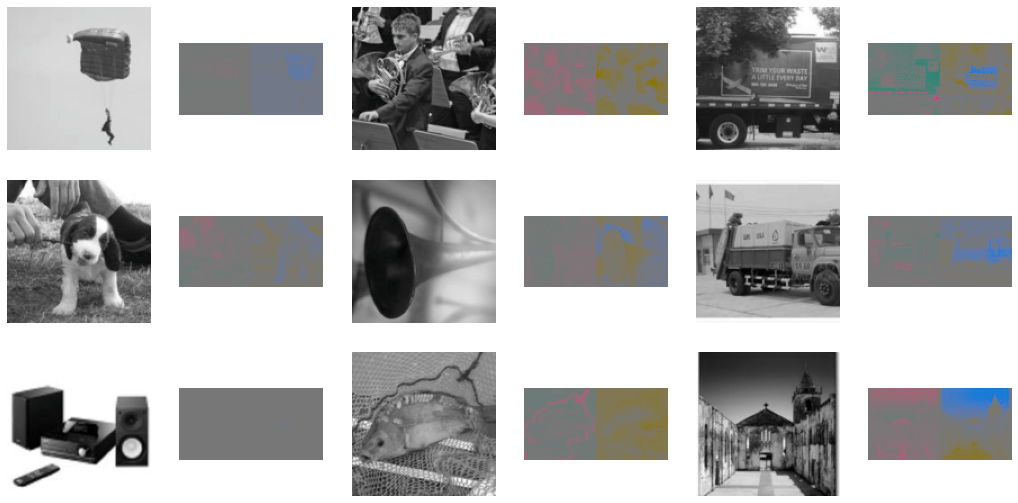

In [ ]:
set_seed(13)
dls = tls.dataloaders(after_batch=[AdjustType(), IntToFloatTensor(), Normalize.from_stats(mean=[0.5],std=[1])])
b = dls.one_batch()
print(f'L channel (input) going from {b[0].min():.2f} to {b[0].max():.2f}')
print(f'A channel (output) going from {b[1][:,0].min():.2f} to {b[1][:,0].max():.2f}')
print(f'B channel (output) going from {b[1][:,1].min():.2f} to {b[1][:,1].max():.2f}')
dls.show_batch()

# Export -

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.ipynb.
Converted index.ipynb.
